# Olist : clusterisation - EDA

In [188]:
#librairies import

import pandas as pd
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from datetime import datetime

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering

from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

In [189]:
data = pd.read_csv('data/olist_customers_whole.csv')

In [190]:
data.head()

,customer_unique_id,first_purchase,last_purchase,total_orders,total_spent,average_review_score,all_comments,total_price_items,total_freight_value,product_categories,seller_cities,order_statuses
0,8d50f5eadf50201ccdcedfb9e2ac8455,2017-05-15 23:30:03,2018-08-20 19:14:26,17,927.63,NaN,NaN,729.62,172.42,"construcao_ferramentas_ferramentas, esporte_la...","campinas, curitiba, joinville, londrina, sao j...","delivered, shipped, unavailable"
1,3e43e6105506432c953e165fb2acf44c,2017-09-18 18:53:15,2018-02-27 18:36:39,9,1963.58,NaN,NaN,1000.85,171.82,"cama_mesa_banho, casa_construcao, informatica_...","ibitinga, jaguariuna, porto alegre, rio de jan...",delivered
2,6469f99c1f9dfae7733b25662e7f1782,2017-09-19 01:02:44,2018-06-28 00:43:34,7,973.09,NaN,NaN,664.20,94.63,cama_mesa_banho,"ibitinga, piracicaba, sao paulo",delivered
3,ca77025e7201e3b30c44b472ff346268,2017-10-09 12:34:39,2018-06-01 11:38:29,7,2126.44,NaN,NaN,806.61,316.11,"cama_mesa_banho, cool_stuff, moveis_decoracao,...","ibitinga, pedreira, sao paulo",delivered
4,1b6c7548a2a1f9037c1fd3ddfed95f33,2017-11-13 16:44:41,2018-02-14 13:22:12,7,1386.54,NaN,NaN,855.21,165.91,"beleza_saude, moveis_decoracao, papelaria, per...","formiga, itajai, mogi das cruzes, pedreira, sa...",delivered


In [191]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96096 entries, 0 to 96095
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   customer_unique_id    96096 non-null  object 
 1   first_purchase        96096 non-null  object 
 2   last_purchase         96096 non-null  object 
 3   total_orders          96096 non-null  int64  
 4   total_spent           96095 non-null  float64
 5   average_review_score  279 non-null    float64
 6   all_comments          120 non-null    object 
 7   total_price_items     95420 non-null  float64
 8   total_freight_value   95420 non-null  float64
 9   product_categories    94107 non-null  object 
 10  seller_cities         95420 non-null  object 
 11  order_statuses        96096 non-null  object 
dtypes: float64(4), int64(1), object(7)
memory usage: 8.8+ MB


In [192]:
data['average_review_score'].describe()

count    279.000000
mean       4.014337
std        1.429321
min        1.000000
25%        3.000000
50%        5.000000
75%        5.000000
max        5.000000
Name: average_review_score, dtype: float64

In [193]:
#need to translate last_purchase into datetime for later use
columns_to_translate_into_datetime = ['last_purchase', 'first_purchase']

data[columns_to_translate_into_datetime] = data[columns_to_translate_into_datetime].apply(pd.to_datetime)

In [194]:
#How many different product categories are there
pc = data['product_categories']
pc.nunique()

668

Product categories will probably not be usable, as there are so many of them

#### NAN identification and treatment

In [197]:
#Missing values exploration function
def null_table(df):
    missing_values = df.isnull().sum()
    missing_values_percent = (missing_values*100)/len(df)
    table = pd.concat([missing_values, missing_values_percent], axis=1)
    table_renamed = table.rename(
        columns = {0 : "Missing Values", 1  : "Percentage of total"})
    final_table = table_renamed[table_renamed.iloc[:,0] != 0].sort_values(
        by='Missing Values', ascending=False).round(2)
    
    return final_table

In [198]:
null_table(data)

,Missing Values,Percentage of total
all_comments,95976,99.88
average_review_score,95817,99.71
product_categories,1989,2.07
total_price_items,676,0.70
total_freight_value,676,0.70
seller_cities,676,0.70
total_spent,1,0.00


In [199]:
#filling function
def fill_with_median(data, column):
    median = data[column].median()
    data[column] = data[column].fillna(median)

    return data

In [200]:
'''
NOT FILLING IT NOW - it needs proper correlation analysis. The filling will take place after

# removing nan from the features we will use
data = fill_with_median(data, ['total_freight_value', 'total_price_items', 'total_spent'])

# checking for nan again
null_table(data)'''

"\nNOT FILLING IT NOW - it needs proper correlation analysis. The filling will take place after\n\n# removing nan from the features we will use\ndata = fill_with_median(data, ['total_freight_value', 'total_price_items', 'total_spent'])\n\n# checking for nan again\nnull_table(data)"

all_comments and average_review_score are over 99% empty, and therefore unusable for our analysis \
We will also drop seller cities, as these information concerns seller and not customers (should adjust SQL query accoringly)\
We will drop them before any other treatment

CAUTION ! These features could be very interesting, should they be better filled in the future ! \
Each instances of re-training should be accompanied by a new exploration regarding these features ! 

### A short review of outliers populations

#### Outliers detection

In [204]:
# with IQR
numerical_features = ['total_freight_value', 'total_price_items', 'total_spent']

for col in numerical_features:
    
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
    total = len(outliers)
    outlier_percentage = round((total/len(data))*100, 2)
    
    print(col, total, 'outliers detected')
    print(outlier_percentage, '% of column')
    
    ''' # Visualize outliers using a box plot
    plt.boxplot(data[col], showfliers=True, sym='o')
    plt.title(f'Box Plot of {col}')
    plt.xlabel('Feature')
    plt.ylabel(col)
    plt.show()'''

total_freight_value 9035 outliers detected
9.4 % of column
total_price_items 8124 outliers detected
8.45 % of column
total_spent 9441 outliers detected
9.82 % of column


IQR method seems more severe. Due to the lack of data, we will try to increase its quality by applying sever corrections \
CAREFUL !! Apply changes only to customers with only 1 order. Rest of them are rare

#### Outliers treatment

Since more than 5% of columns are outliers, we will try either to replace outliers with median or perhaps an IterativeImputer, if correlated pairs are identified

In [208]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

def iterative_filling(df, threshold):
    #identify NUMERCIAL values
    numerical_to_fill = df.select_dtypes(np.number)
    #analyze correlation
    corrmap = numerical_to_fill.corr()
    #defining threshold
    mask = np.abs(corrmap) > threshold
    #preparing the pairs
    correlated_pairs = []
    # Iterate over the correlation matrix
    for i in range(len(corrmap.columns)):
        for j in range(i+1, len(corrmap.columns)):  # Start from i+1 to avoid self-comparison
            if np.abs(corrmap.iloc[i, j]) > threshold:
                # Append the pair of feature names if above threshold
                correlated_pairs.append([corrmap.columns[i], corrmap.columns[j]])
    
    #initialize iterative imputer
    iter_imputer = IterativeImputer(max_iter=10, random_state=42)

    #imputing pair by pair
    for pair in correlated_pairs:
        # Select only the columns in the pair for imputation
        df_pair = df[pair]
        # Apply imputation
        df_imputed = iter_imputer.fit_transform(df_pair)
        # Update the original DataFrame with the imputed values
        df[pair] = df_imputed
    
    return df

In [209]:
#first turn outliers into nans

for col in numerical_features:
    
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    #modifying ONLY those with 1 order
    data.loc[(data[col] < lower_bound) | (data[col] > upper_bound) & (data['total_orders']==1), col] = np.nan

#then fill nans with function
data = iterative_filling(data, 0.80)

In [210]:
# how many data have not been filled due to lack of correlation ?
null_table(data)

,Missing Values,Percentage of total
all_comments,95976,99.88
average_review_score,95817,99.71
total_spent,8614,8.96
total_freight_value,8572,8.92
total_price_items,8091,8.42
product_categories,1989,2.07
seller_cities,676,0.70


In [211]:
# filling uncorrelated data with precedently used filling function
data = fill_with_median(data, ['total_freight_value', 'total_price_items', 'total_spent'])

#### Visual representation

<function matplotlib.pyplot.show(close=None, block=None)>

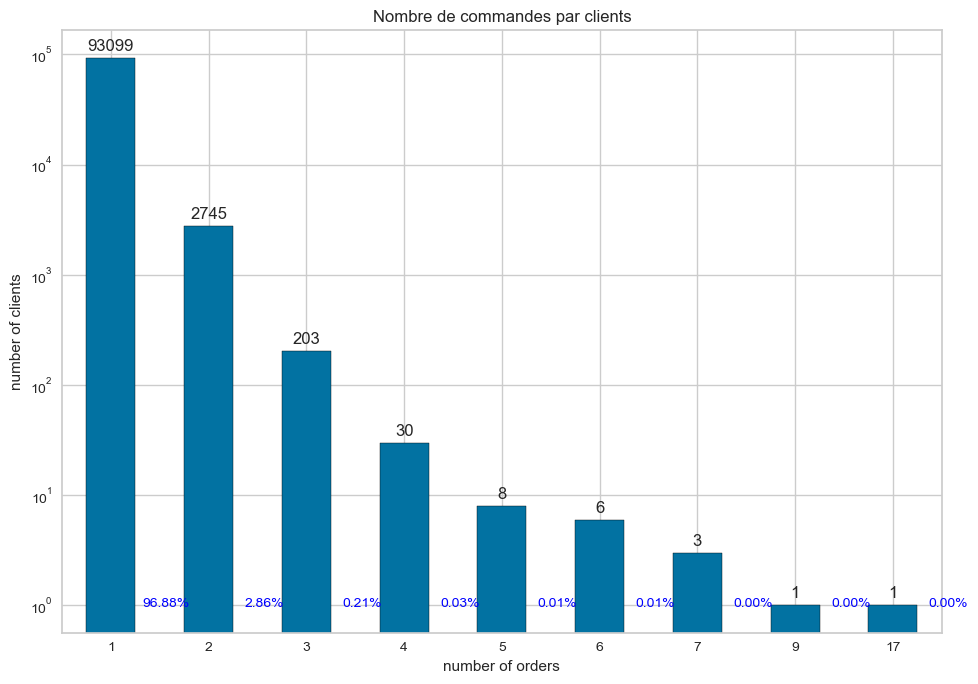

In [213]:
#plotting the number of orders by clients
fig = plt.figure(figsize=(10, 7))
x = data['total_orders'].value_counts().sort_index()
total = x.sum()
ax = x.plot(kind='bar', edgecolor='black')

for xaxis, yaxis in enumerate(x):
    ax.annotate(str(yaxis), xy=(xaxis, yaxis),  xytext=(0, 5), textcoords='offset points', ha='center')

for xaxis, yaxis in enumerate(x):
    percentage = (yaxis / total) * 100
    ax.annotate(f'{percentage:.2f}%', xy=(xaxis, 1),  xytext=(40, 5), textcoords='offset points', ha='center', va='top', fontsize=10, color='blue')

plt.yscale('log')
plt.xlabel('number of orders')
plt.xticks(rotation=0)
plt.ylabel('number of clients')
plt.title('Nombre de commandes par clients')
plt.tight_layout()

plt.show

piechart : 1 commande VS les autres

On constate qu'à peine plus que 3% des clients on fait plus qu'une seule commande

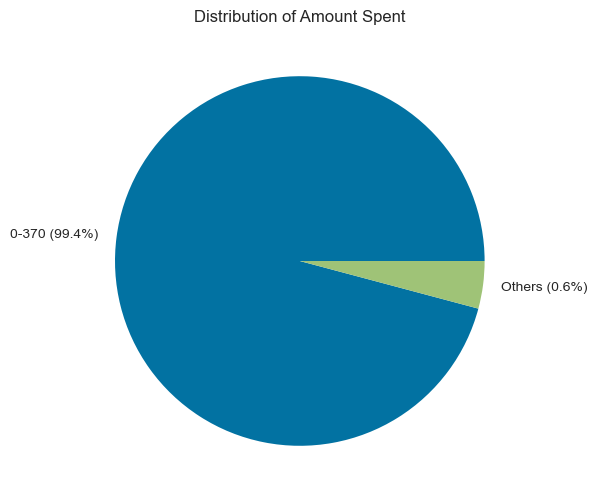

In [216]:
# Calculate the bin edges and counts
n, bins = np.histogram(data['total_price_items'], bins=20)

# Calculate the total amount spent in each bin
bin_totals = [data['total_price_items'][(data['total_price_items'] >= bins[i]) & (data['total_price_items'] < bins[i+1])].sum() for i in range(len(bins)-1)]

# Calculate the percentage of people in each bin
total_people = len(data)
percent_people = [(data['total_price_items'][(data['total_price_items'] >= bins[i]) & (data['total_price_items'] < bins[i+1])].count() / total_people) * 100 for i in range(len(bins)-1)]

# Create labels for the pie chart
bin_labels = [f'{int(bins[i])}-{int(bins[i+1])} ({percent_people[i]:.1f}%)' for i in range(len(bins)-1)]

# Group the bins with small percentages into an 'Others' category
threshold = 5  # percentage

# Initialize lists for the new labels and totals
new_bin_totals = []
new_bin_labels = []

# Track totals for 'Others' category
others_total = 0
others_percentage = 0

# Iterate through the bins and group small percentages
for total, label, percentage in zip(bin_totals, bin_labels, percent_people):
    if percentage >= threshold:
        new_bin_totals.append(total)
        new_bin_labels.append(label)
    else:
        others_total += total
        others_percentage += percentage

# Add the 'Others' category if needed
if others_total > 0:
    new_bin_totals.append(others_total)
    new_bin_labels.append(f'Others ({others_percentage:.1f}%)')

# Create the pie chart with the new bins
plt.figure(figsize=(10, 6))
plt.pie(new_bin_totals, labels=new_bin_labels, startangle=0)
plt.title('Distribution of Amount Spent')
plt.show()

97.4% des clients ont un panier moyen de 120 Reals

### RFM : Récence Fréquence Montant

In [219]:
#Recence

#calculate the time since last seen
#current_date = pd.to_datetime(datetime.now().date()) #maybe not use the current date but last date of DB update ('2021-10-01')
DATABASE_UPDATE = pd.to_datetime('2021-01-01') #should be constant since information comes from outside

data['days_since_last_purchase'] = (DATABASE_UPDATE - data['last_purchase']).dt.days

# Insert the new column after the last_seen column
last_purchase_index = data.columns.get_loc('last_purchase')
data.insert(last_purchase_index + 1, 'days_since_last_purchase', data.pop('days_since_last_purchase'))

data.head()

,customer_unique_id,first_purchase,last_purchase,days_since_last_purchase,total_orders,total_spent,average_review_score,all_comments,total_price_items,total_freight_value,product_categories,seller_cities,order_statuses
0,8d50f5eadf50201ccdcedfb9e2ac8455,2017-05-15 23:30:03,2018-08-20 19:14:26,864,17,927.63,NaN,NaN,729.62,172.42,"construcao_ferramentas_ferramentas, esporte_la...","campinas, curitiba, joinville, londrina, sao j...","delivered, shipped, unavailable"
1,3e43e6105506432c953e165fb2acf44c,2017-09-18 18:53:15,2018-02-27 18:36:39,1038,9,1963.58,NaN,NaN,1000.85,171.82,"cama_mesa_banho, casa_construcao, informatica_...","ibitinga, jaguariuna, porto alegre, rio de jan...",delivered
2,6469f99c1f9dfae7733b25662e7f1782,2017-09-19 01:02:44,2018-06-28 00:43:34,917,7,973.09,NaN,NaN,664.20,94.63,cama_mesa_banho,"ibitinga, piracicaba, sao paulo",delivered
3,ca77025e7201e3b30c44b472ff346268,2017-10-09 12:34:39,2018-06-01 11:38:29,944,7,2126.44,NaN,NaN,806.61,316.11,"cama_mesa_banho, cool_stuff, moveis_decoracao,...","ibitinga, pedreira, sao paulo",delivered
4,1b6c7548a2a1f9037c1fd3ddfed95f33,2017-11-13 16:44:41,2018-02-14 13:22:12,1051,7,1386.54,NaN,NaN,855.21,165.91,"beleza_saude, moveis_decoracao, papelaria, per...","formiga, itajai, mogi das cruzes, pedreira, sa...",delivered


Features RFM retenues : 
- last_purchase = Récence
- days_since_last_purchase = Fréquence
- total_price_items = Montant

In [221]:
#New df with only the 3 needed features
columns_RFM = ['last_purchase', 'days_since_last_purchase', 'total_price_items']
data_RFM = data[columns_RFM]

data_RFM

,last_purchase,days_since_last_purchase,total_price_items
0,2018-08-20 19:14:26,864,729.62
1,2018-02-27 18:36:39,1038,1000.85
2,2018-06-28 00:43:34,917,664.20
3,2018-06-01 11:38:29,944,806.61
4,2018-02-14 13:22:12,1051,855.21
...,...,...,...
96091,2018-06-06 10:46:09,939,223.00
96092,2017-12-17 23:31:33,1110,59.00
96093,2017-08-04 23:18:15,1245,143.80
96094,2018-08-12 20:27:59,872,30.00


In [222]:
data_RFM.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96096 entries, 0 to 96095
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   last_purchase             96096 non-null  datetime64[ns]
 1   days_since_last_purchase  96096 non-null  int64         
 2   total_price_items         96096 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 2.2 MB


### Export cleaned data and built data_RFM dataframes

In [224]:
data.to_csv('data/data_cleaned.csv', index = False)
data_RFM.to_csv('data/data_RFM.csv', index = False)